In [2]:
import pandas as pd
import numpy as np
from RexR import *
import _helpers
Rocket = RexR(datalocation = '_data/genomic_data/data.pkl', seed = 3123, debug = False, write_out=True) # '_data/genomic_data/data.pkl'
Rocket.load_probeset_data();

++++++++++++++++++++++++++++++ Firing up RexR! ++++++++++++++++++++++++++++++


In [3]:
from math import*
#from scipy.dspatial.distance import cosine
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cdist
from decimal import Decimal
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from time import time
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from itertools import cycle

In [4]:
TransPosed = Rocket.DATA_all_samples.T # all microarrays, may be multiple per patient versus all probesets, may be multiple per genome
Normal = Rocket.DATA_all_samples
AllNormal = Rocket.DATA_merged
#probeset_weights = Rocket.get_probeset_weights(method = )

In [5]:
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [8]:
VarList = TransPosed.keys()
output = pd.DataFrame()
count = 0
i = 0
j = 0
lim = len(VarList) 
inflation = 1
start = time()
for var_x in VarList:
    row = []
    j = 0
    for var_y in VarList:
        #sim_value = (minkowski_distance(TransPosed[var_x], TransPosed[var_y], 1))**inflation
        sim_value = minkowski(u = TransPosed[var_x], v = TransPosed[var_y], p =1)
        row.append(sim_value)        
        j = j + 1
        if(j>lim): break
    i = i + 1
    if(i>lim): break
    count = count + 1
    #print(" Processed similarity for:", var_x, len(VarList)-count, " more to go")
    row_ts = pd.Series(row)
    row_ts.name = var_x
    output = output.append(row_ts)
print("runtime is", time()-start)
output.columns= VarList[:lim+1]
output[:5]

KeyboardInterrupt: 

# Patient clustering

In [12]:
# get patient similarity
#########################


def patient_similarity(patient_matrix, sim_type = 'cosine', minkowski_dim = None, normalised = True, inflation = 1):
    ''' Function to get similarity measures between patients  
        Variables:
            patient_matrix : dataframe with patient 1..N as columns and genome expressions 1..M as rows.
            sim_type : type of similarity measure
                values : 'cosine', 'manhattan', 'euclidian', 'minkowski', 'kendall', 'spearman', 'pearson',
                ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘dice’,‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, 
                ‘matching’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’
            minkowski_dim : dimensionality of minkowski space
                values : 3,4...inf (1= is manhattan, 2=euclidian)
            normalised : boolean
        output : 
            similarity matrix (DataFrame)       
    '''
    
    if len(patient_matrix<1000): 
        if (sim_type in ['cosine', 'manhattan', 'euclidian', 'minkowski', 'braycurtis', 'canberra', 'chebyshev', 'dice','hamming', 'jaccard', 'kulsinski', 'mahalanobis', 
                    'matching', 'rogerstanimoto', 'russellrao', 'seuclidean', '‘sokalmichener', 'sokalsneath']):
            A = np.array(patient_matrix)
        else:
            A = None
        VarList = patient_matrix.T.keys()
        if(sim_type == 'cosine'):        
            similarities = cdist(A, A, metric = 'cosine')
            patient_similarity = pd.DataFrame(similarities, index = VarList, columns = VarList)
        elif(sim_type == 'manhattan'):
            similarities = cdist(A, A, metric = 'cityblock')
            patient_similarity = pd.DataFrame(similarities, index = VarList, columns = VarList)        
        elif(sim_type == 'euclidian'):
            similarities = cdist(A, A, metric = 'euclidean')
            patient_similarity = pd.DataFrame(similarities, index = VarList, columns = VarList)
        elif(sim_type == 'minkowski'):
            if (minkowski_dim == None):
                print("No Minkowski dimension given! Assuming minkowski dim is 3")
                minkowski_dim = 3
            similarities = cdist(A, A, metric = 'minkowski', p = minkowski_dim)
            patient_similarity = pd.DataFrame(similarities, index = VarList, columns = VarList)       
        elif(sim_type in ['kendall', 'spearman', 'pearson']):
            patient_similarity = 1-patient_matrix.T.astype('float64').corr(method = sim_type)    
        elif(sim_type in ['braycurtis', 'canberra', 'chebyshev', 'dice','hamming', 'jaccard', 'kulsinski', 'mahalanobis', 
                    'matching', 'rogerstanimoto', 'russellrao', 'seuclidean', '‘sokalmichener', 'sokalsneath']):
            similarities = cdist(A, A, metric = sim_type)
            patient_similarity = pd.DataFrame(similarities, index = VarList, columns = VarList)       
        ###
        if inflation > 1:
            patient_similarity = patient_similarity**inflation
        ###                                                               
        if normalised == True: # ! IMPROVE, not memory efficient
            patient_similarity = (patient_similarity - min(patient_similarity.min()))/(max(patient_similarity.max())-min(patient_similarity.min()))

        patient_similarity = 1 - patient_similarity
    else:
        raise ValueError('More than 1000 samples not supported at this moment')
    ###
    return patient_similarity

In [23]:
patient_sim = patient_similarity(Normal, sim_type = 'cosine', normalised = True, inflation = 2, minkowski_dim=1)
##### apply Markov clustering
#######################
# non-distributed, non-sparse version, only for small-sized problems (N is order 1000)
e = 2
r = 2 
epsilon = 1e-7
convergence = 0.001
num_iter = 12
Orientation = 'col' # columnwise or rowwise

# add loop
def add_loop(df_matrix, value=0): 
    for i in df_matrix.index:
        df_matrix.loc[i, i] = value
    return df_matrix
patient_sim = add_loop(patient_sim, 1)
patient_sim = patient_sim - epsilon

def normalise(sim, type = 'col'):
    if(type == 'col'):
        # column normalisation
        for variable in sim.keys():
            col_vec = sim[variable]
            sum_val = sum([p for p in col_vec])
            sim[variable] = sim[variable]/sum_val
    elif (type == 'row'):
        # row normalisation
        for variable in sim.keys():
            row_vec = sim.loc[variable, :]
            sum_val = sum([p for p in row_vec])
            sim.loc[variable,:] = sim.loc[variable,:]/sum_val
    return sim

# step E: expansion, get the nth power of the matrix
def expansion(sim):
    X = numpy.array(sim)
    VarList = sim.keys()
    if e == 1:
        return sim
    elif e > 1:        
        return pandas.DataFrame(numpy.linalg.matrix_power(X, e), index = VarList, columns = VarList)
     
# step I: inflation, per column raise by rth power and column normalise
def inflation(sim, type = 'col'):    
    if type == 'col':
        Axis = 0
    elif type == 'row':
        Axis = 1
    return sim.apply(lambda x: x**r/sum(x**r), axis = Axis)

# remove weak connections, values < epsilon
def clean(sim):
    return sim.applymap(lambda x:0 if x<epsilon else x)
    
def difference(old, new):
    # relative zeroes over entire array
    #return (new.apply(lambda x: numpy.ceil(x-epsilon)) - old.apply(lambda x: numpy.ceil(x-epsilon))).sum().sum()/len(old)**2    
    return abs(new - old).sum().sum()/len(old)**2    

#patient_sim = normalise(patient_sim, type = Orientation)
_sim_a = patient_sim
for i in range(0,num_iter):
    # repeat E and I until convergence, the row-wise elements form the clusters.
    _sim_b = clean(inflation(expansion(_sim_a), type = Orientation))
    #if ((difference(_sim_a, _sim_b)) < convergence) & (i>0):
    #    print(difference(_sim_a, _sim_b))
    #    print("CONVERGED after ", i, " iterations")
    #    break;
    _sim_a = _sim_b

result_mcl = clean(_sim_b)
result_mcl.loc[result_mcl.loc['9827_corr2.CEL',:]>epsilon, '9827_corr2.CEL']
# fetch clusters
#############



Series([], Name: 9827_corr2.CEL, dtype: float64)

In [18]:
patient_sim = patient_similarity(Normal, sim_type = 'pearson', normalised = True, inflation=1, minkowski_dim=1)
##### apply Affinity Propagation
#######################
X = np.array(patient_sim)
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
cluster_labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print("Cluster centers:",patient_sim.keys()[cluster_centers_indices].values)
print(af.labels_)

Cluster centers: ['KGK_Tall_JL_7415.CEL' '1509.CEL' '8639.CEL']
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 1 0
 0 0 0 0 0 0 0 1 2 2 2 1 0 2 1 2 1 1 2 2 0 2 2 2 2 2 2 1 1 1 2 2 2 0 2 1 2
 2 1 2 2 2 2 2 1 2 1 2 2 0 2 2 1 2 2 1 1 1 2 2 1 2 2 2 2 2 1 2 0 0 0 2 0 2
 2 2 1 1 1 2 2 2 2 1 0 2 1 2 2 0 0 1 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2]


In [116]:
AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)].groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'FU_RFS': numpy.mean })

,FU_RFS


In [117]:
AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)]['FU_RFS']

1       75.000000
2       64.000000
3       64.000000
4       72.000000
5       31.000000
6      183.000000
7      141.000000
8       67.000000
9       86.000000
10       2.000000
11     139.000000
12     111.000000
13     114.000000
14      14.000000
15       9.000000
16      19.000000
17      62.000000
18      63.000000
19      13.000000
20       9.000000
21      83.000000
22     132.000000
23      12.000000
24      87.000000
25     136.000000
26       8.000000
27       8.000000
28      74.000000
29      74.000000
30      37.000000
          ...    
101      7.000000
102    106.849315
103     94.093151
104     37.972603
105     67.594521
106     78.115068
107     61.512329
108     11.802740
109     11.704110
110      9.000000
111      9.000000
112     99.682192
113     19.002740
114     19.002740
115      0.821918
116     48.427397
117     55.232877
118     13.446575
119     85.216438
120     63.090411
121     95.572603
122     83.605479
123     82.290411
124     79.167123
125     50

In [115]:
AggResults = Rocket.DATA_merged
AggResults = _helpers._preprocess(AggResults)
AggResults = _helpers._group_patients(AggResults, method = 'mean')
AggResults['cluster_ap'] = cluster_labels
AggResults['FU_RFS'] = pandas.to_numeric(AggResults['FU_RFS'])
#AggResults.groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'Microarray file': pandas.Series.nunique})
AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)].groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'FU_RFS': numpy.mean })

c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,,FU_RFS
Treatment risk group in ALL10,cluster_ap,


Cluster centers: ['KGK_Tall_JL_7415.CEL' '1509.CEL' '8639.CEL']
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 1 0
 0 0 0 0 0 0 0 1 2 2 2 1 0 2 1 2 1 1 2 2 0 2 2 2 2 2 2 1 1 1 2 2 2 0 2 1 2
 2 1 2 2 2 2 2 1 2 1 2 2 0 2 2 1 2 2 1 1 1 2 2 1 2 2 2 2 2 1 2 0 0 0 2 0 2
 2 2 1 1 1 2 2 2 2 1 0 2 1 2 2 0 0 1 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2]


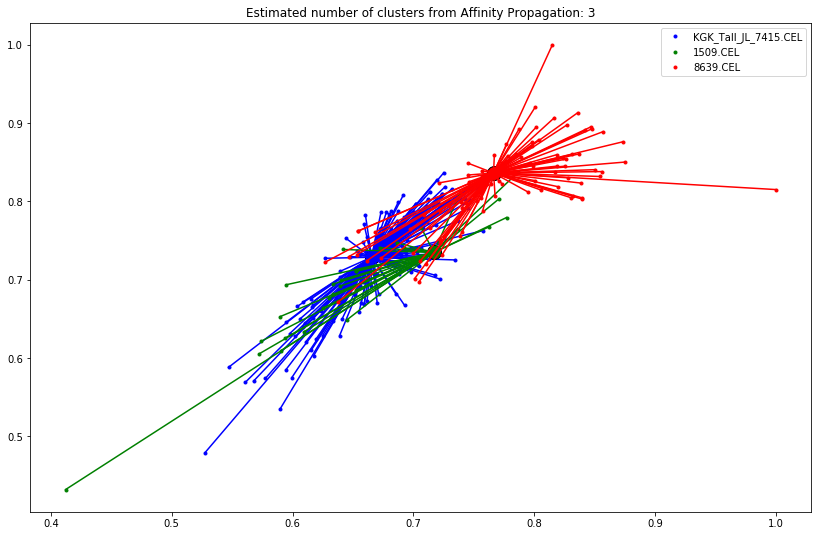

In [19]:
print("Cluster centers:",patient_sim.keys()[cluster_centers_indices].values)
print(cluster_labels)

plt.close('all')
plt.figure(figsize=(14,9))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = cluster_labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.', 
             label = patient_sim.keys()[cluster_centers_indices[k]])
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.legend()
        
plt.title('Estimated number of clusters from Affinity Propagation: %d' % n_clusters_)
plt.show()

In [19]:
##### CREATE graph from similarity matrix
##################
# nodes
VarList = TransPosed.keys()
nodes = []
node_index = 0
for patient_name in VarList:
    nodes.append((node_index, {'name': patient_name}))
    node_index = node_index + 1

edges = []
# edges
patient_sim = patient_similarity(Normal, sim_type = 'pearson', normalised = True, inflation=2)
node_index_x = 0
node_index_y = 0
for patient_name_x in VarList:
    for patient_name_y in VarList:        
        edges.append((node_index_x, node_index_y, patient_sim.iloc[node_index_x, node_index_y]))
        node_index_y = node_index_y + 1
    node_index_x = node_index_x + 1
    node_index_y = 0

In [20]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges, weight = 'weight')

c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

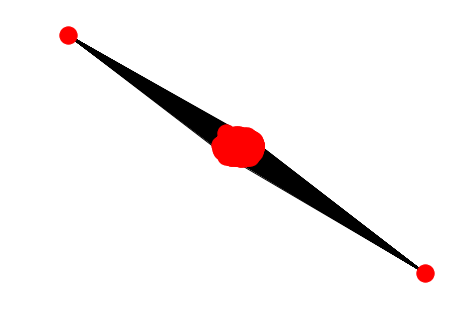

In [23]:
##### apply Spring-force
#######################
pos = nx.spring_layout(G, k = None, dim = 3, scale = 1.0)
nx.draw_spring(G, k = 30, dim = 2, scale = 1.0, iterations =1500)
plt.show()

In [ ]:
##### APPLY community detector
# maximize betweenness and modularity
##################################


In [12]:
##### LOAD IN DATA
###################
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
# 

In [15]:
df = _helpers._preprocess(Rocket.DATA_merged) 
df = _helpers._group_patients(df, method = 'mean')

KeyboardInterrupt: 

In [5]:
x,y =_helpers._get_matrix(df, features = 'genomic', target = 'Treatment risk group in ALL10')

In [20]:
preds, class_model = Rocket.classify_treatment(model_type = 'RandomForest', 
                                              features = 'genomic',
                                              parameters = {},
                                              pipeline = {"scaler": {"type": "minmax"},
                                                        "dim_reduction": {"type": "PCA", "n_comp": 1000},
                                                        "feature_selection": {"type": "RFECV", "top_n": 100}})

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Prepping data, this may take a while..
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Grouping probesets


KeyError: 'pre_processing'

In [15]:
preds

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0], dtype=int64)

In [14]:
preds = [pred_[1]for pred_ in preds]
#len(Rocket.DATA_merged[Rocket.DATA_merged["array-batch"].isin(["cohort 1", "cohort 2", "JB", "IA", "ALL-10"])])
Results = Rocket.DATA_merged_processed
Results['pred'] = preds
print(Results[:311][['labnr patient', 'pred', 'Treatment risk group in ALL10']])

IndexError: invalid index to scalar variable.